# Homework 5

by Maia Rosengarten <br/>
SID: 23572580<br/>
March 27, 2017<br/>

In [1]:
import matplotlib
import numpy as np
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy.stats import logistic as sig
import pandas as pd

np.set_printoptions(threshold=np.nan)
from scipy import io
import sklearn
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import DictVectorizer as dv
from sklearn.preprocessing import Imputer as imp
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

# NP FNS

In [2]:
def vec(arr): # d b 1 --> (d, 1)
    return arr.reshape((arr.shape[0], 1))

In [3]:
def arr(vec): # 1 by d --> (d, )
    return vec.flatten()

# PREPROCESSING FNS

In [5]:
def preProcessData(dataDF, lstCatFeat, lstNumericFeat, lstDummies):
    '''
        Iterates over every value of every feature and replaces '?' (missing) with
        feature mean (if quantitative) and feature mode (if categorical)
        
        Args:
            designMatrixDF (pandas data frame) - dataframe of design matrix
            lstCatFeatIndices (lst) - list of indices of features that are categorical
            lstNumFeatIndices (lst) - list of indices of features that are numeric
    
    '''
#     dataDF = dataDF.dropna(axis=1, how='all') #idk if works
    dataDF.dropna(axis=0, how='all', inplace=True) #idk if works

    copyDataDF = dataDF.copy()
    for feat in lstNumericFeat:
        copyDataDF[feat].fillna(round(dataDF[feat].mean(), 2), inplace=True)
    for feat in lstCatFeat:
        copyDataDF[feat].fillna(dataDF[feat].mode()[0], inplace=True)         
    copyDataDF = pd.get_dummies(copyDataDF, columns=lstDummies)
    return copyDataDF
    

# UTIL FNS

In [6]:
def plotAccuracies(accuracies, depths):
    '''
        Plots accuracies as a function od depth
        Args:
            costs (ndarray) - lst of costs per iteration of gradient descent
    '''
   
    plt.plot(depths, accuracies)
    plt.title("Prediction Evaluation Decision Tree On Census Data")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()

In [7]:
def generateCsv(aryPredictions, strCsvName):
    '''
    Writes predictions of testSet to csv file
    Args:
        aryPredictions (ndarray) - (nx1)-array of predictions given size n test (or valid) set
        strCsvName (str) - name of csv file to write to
    '''
    with open(strCsvName + '.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(aryPredictions)):
            writer.writerow([i, aryPredictions[i]])
    csvfile.close()

# 1. DECISION TREE IMPLEMENTATION

In [147]:
class DecisionTree:
    def __init__(self, root=None, max_depth=50, leaf_condition=1):
        self.root = root
        self.max_depth = max_depth
        self.leaf_condition = leaf_condition
    
    def train(self, train_data, train_labels, sizeFeatSubset):
        '''
            Sets the root of the decision tree to the root node of the resulting tree from buildTree.
            Args:
                train_data (ndarray) - cleaned training data
                train_lablels (ndarray) - cleaned training labels
                height_cap (int) - prevents tree from growing too large
        
        '''
        node_depth = 0
        self.root = self.buildTree(train_data, train_labels, self.max_depth, node_depth, sizeFeatSubset, self.leaf_condition)
    
    def buildTree(self, train_data, train_labels, max_depth, node_depth, sizeFeatSubset, leaf_condition=1):
        '''
            Recursively grows a decision tree by constructing nodes. Using the impurity and segmenter methods, 
            attempts to find a configuration of nodes that best splits the input data. 
            This function figures out the split rules that each node should have and figures out 
            when to stop growing the tree and insert a leaf node.  
            
            This phase is training the data.
            
            Args:
                train_data (ndarray) - n by d matrix of cleaned training data
                train_labels (ndarray) - n by 1 vector of training labels
                max_depth (int) - caps the height of the tree to prevent it from growing too large
                
        '''
        numSamples = train_data.shape[0]
        numFeatures = train_data.shape[1]
        numClass1 = np.sum(train_labels)
        numClass0 = numSamples - numClass1
        
        isLeaf, label = self.isMajClassLeaf(numSamples, numClass1, numClass0, leaf_condition)
        if (isLeaf):
            return Node(label=label)
        elif (max_depth==0): 
            if (numClass1 > numClass0):
                label = 1
            else:
                label = 0
            return Node(label=label)  
        else:
            node = Node()
            node.chooseSplitRule(train_data, train_labels, sizeFeatSubset)
            leftIndices = [] 
            rightIndices = [] 

            for i in range(train_data.shape[0]):
                if (train_data[i, node.splitFeatIndex] <= node.splitVal):
                    leftIndices.append(i)
                else:
                    rightIndices.append(i)
            
            leftSetX = train_data[leftIndices, :]
            leftSetY = train_labels[leftIndices]

            
            rightSetX = train_data[rightIndices, :]
            rightSetY= train_labels[rightIndices]

            sizeRightSet = len(rightSetX)
            sizeLeftSet = len(leftSetX)
            
            if (sizeRightSet==0):
                if (np.sum(rightSetY) > sizeRightSet/2):
                    return Node(label=1)
                return Node(label=0)
            
            if (sizeLeftSet==0):
                if (np.sum(leftSetY)> sizeLeftSet/2):
                    return Node(label=1)
                return Node(label=0)
                
            max_depth -=1
            node_depth+=1
            return Node(featureIndex=node.splitFeatIndex, splitVal=node.splitVal, leftChild=self.buildTree(leftSetX, leftSetY, max_depth, node_depth, sizeFeatSubset, leaf_condition), rightChild=self.buildTree(rightSetX, rightSetY, max_depth, node_depth, sizeFeatSubset, leaf_condition), parentNode=node, depth=node_depth)
    
         
    def predictPointWithPrint(self, node, data_point, lstFeatures):
        '''
            Given a data point, traverse the tree to find the best label to classify the data point. 
            Start at the root node and evaluate split rules as you traverse until you reach a leaf. 
            Choose that leaf nodes label as your output label.
            
            data_point (ndarray) - (dx1) single point to classify with d features 
        
        '''
        if (node is None):
            print('Error: root in tree is None')
            return None
        if (node.label is not None):
            tortn = node.label
            print('Therefore the class is ' + str(tortn) + "\n")
            return tortn  
        if (data_point[node.splitFeatIndex] <= node.splitVal):
            print("('" + str(lstFeatures[node.splitFeatIndex] + "') <= " + str(node.splitVal)))
            return self.predictPointWithPrint(node.left, data_point, lstFeatures)
        else:
            print("('" + str(lstFeatures[node.splitFeatIndex] + "') > " + str(node.splitVal)))      
            return self.predictPointWithPrint(node.right, data_point, lstFeatures)
    
    def predictWithPrint(self, dataMatrix, dataLabels, lstFeatures):
        '''
            Given a matrix of test samples, predict labels.
            
            dataMatrix (ndarray) - (nxd) unseen samples with d dimensions 
        ''' 
        predictions = []
        for i in range(dataMatrix.shape[0]):
            print("Predicting sample" + str(i) + ": ")
            print("Actual class: " + str(dataLabels[i]))
            label = self.predictPointWithPrint(self.root, dataMatrix[i], lstFeatures)
            predictions.append(label)
        return predictions
                    
    
    def predictPoint(self, node, data_point):
        '''
            Given a data point, traverse the tree to find the best label to classify the data point. 
            Start at the root node and evaluate split rules as you traverse until you reach a leaf. 
            Choose that leaf nodes label as your output label.
            
            data_point (ndarray) - (dx1) single point to classify with d features 
        
        '''
        if (node is None):
            print('Error: root in tree is None')
            return None
        if (node.label is not None):
            return node.label  
        if (data_point[node.splitFeatIndex] <= node.splitVal):
            return self.predictPoint(node.left, data_point)
        else:
            return self.predictPoint(node.right, data_point)
    
    def predict(self, dataMatrix):
        '''
            Given a matrix of test samples, predict labels.
            
            dataMatrix (ndarray) - (nxd) unseen samples with d dimensions 
        ''' 
        predictions = []
        for i in range(dataMatrix.shape[0]):
            label = self.predictPoint(self.root, dataMatrix[i])
            predictions.append(label)
        return predictions
    
    def isMajClassLeaf(self, numSamples, numClass1, numClass0, threshold):
        '''
            Returns (True, y) if threshold% of points in a node are of a particular class
            where y is the label of the leaf.

        '''     
        if (numClass1 >= (threshold * numSamples)):
            return True, 1
        elif (numClass0 >= (threshold * numSamples)):
            return True, 0
        return False, None
    
    def visualize_tree(self, filename):
        graph = pydot.Dot(graph_type="graph")
        visited, queue = set(), [self.root]
        while queue:
            node = queue.pop()
            try:
                if node not in visited:
                    visited.add(node)
                    if node.label is None:
                        parent_node = pydot.Node(str(node.splitFeatIndex + " : " + node.splitVal))
                        if node.left is not None:
                            if node.left.label is not None:
                                left_label = node.left.label
                            else:
                                left_label = str(node.left.splitFeatIndex + " : " + node.left.splitVal)
                            left_node = pydot.Node(left_label)
                            queue.append(left_node)
                            graph.add_edge(pydot.Edge(parent_node, left_node))
                        if node.right is not None:
                            if node.right.label is not None:
                                right_label = node.right.label
                            else:
                                right_label = str(node.right.splitFeatIndex + " : " + node.right.splitVal)
                            right_node = pydot.Node(right_label)
                            queue.append(right_node)
                            graph.add_edge(pydot.Edge(parent_node, right_node))
            except:
                pass
        graph.write_png(filename + '.png')
                        

# 1. RANDOM FOREST IMPLEMENTATION

In [53]:
class RandomForest:
    def __init__(self, numTrees, train_data, train_labels, leaf_condition):
        self.train_data = train_data
        self.train_labels = train_labels
        self.trees = []
        self.numTrees = numTrees
        self.leaf_condition = leaf_condition
        for i in range(self.numTrees):
            self.trees.append(DecisionTree(leaf_condition=self.leaf_condition))          
                     
    def train(self, train_data, sizeFeatSubset):
        for tree in self.trees:
            numSamples = self.train_data.shape[0]
            randomSamples = np.random.choice(numSamples, numSamples, replace=True)
            subset_data = self.train_data[randomSamples]
            subset_labels = self.train_labels[randomSamples]
            tree.train(subset_data, subset_labels, sizeFeatSubset)
    
    def predict(self, valid_data):
        predictions = []
        for point in valid_data:
            labels = []
            for tree in self.trees:
                labels.append(tree.predictPoint(tree.root, point))
            if (np.sum(labels) >= 0.5 * self.numTrees):
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

In [44]:
class Node:
    def __init__(self, featureIndex=0, splitVal=None, leftChild=None, rightChild=None, parentNode=None, label=None, depth=1):
        self.splitFeatIndex = featureIndex 
        self.splitVal = splitVal
        self.left = leftChild
        self.right = rightChild
        self.parent = parentNode
        self.label = label 
        self.depth = depth
    
    
    def chooseSplitRule(self, train_data, train_labels, sizeFeatSubset):
        '''
            Finds the best split rule for a Node using the impurity measure and input data. 
            Exhaustively tries threshold values from the data and chooses the combination of 
            split feature and threshold with the lowest impurity value. 
           
            Args:
               train_data (ndarray) - cleaned train data 
               train_labels (ndarray) - train labels
            
            Returns (bestSplitFeatIndex, bestSplitValue)
                 
            
            If xi is quantitative, sort points in S by feature xi; 
            remove duplicates; [duplicate values, not points]
            try splitting between each pair of consecutive values.
            [We can radix sort the values in linear time, and if n is huge we should.]
            
            Clever Bit: As you scan sorted list from left to right, 
            you can update entropy in O(1) time per point! 
            [This is important for obtaining a fast tree-building time.] <--GO OVER THIS.
            
            Need to deal with case when a child is empty (skip that split)
    
        '''
        #<= split value --> left, > split value --> right
        
        currNodeSize = len(train_data)
        currClass1Count = sum(train_labels) 
        currClass0Count = currNodeSize - currClass1Count
        currNodeEntropy = self.computeEntropy((currNodeSize, currClass0Count, currClass1Count))
        bestInfoGain = -float("inf")
 
        labelDictRight = {0: currClass0Count, 1: currClass1Count}
        labelDictLeft = {0:0, 1:0}
        sizeRightSet = currNodeSize
        sizeLeftSet = 0
        for featureIndex in np.random.choice(train_data.shape[1], sizeFeatSubset, replace=False):
            sortedIndices = np.argsort(train_data[:, featureIndex])
            sortedVals = np.sort(train_data[:, featureIndex])
            
            lstUniqueVal, lstUniqueCounts = np.unique(sortedVals, return_counts=True)
            runningIndex = - 1
            for i in range(len(lstUniqueVal)):
                runningIndex += (lstUniqueCounts[i])
                tempSplitVal = lstUniqueVal[i]
                
                sizeLeftSet = runningIndex + 1
                sizeRightSet = currNodeSize - sizeLeftSet
                
                labelDictLeft[1] = np.sum(train_labels[sortedIndices[:runningIndex+1]])
                labelDictRight[1] = np.sum(train_labels[sortedIndices[runningIndex+1:]])
                labelDictRight[0] = sizeRightSet - labelDictRight[1]
                labelDictLeft[0] = sizeLeftSet - labelDictLeft[1]
                
                tupSizeLeftClassCounts = (sizeLeftSet, labelDictLeft[0], labelDictLeft[1])
                tupSizeRightClassCounts = (sizeRightSet, labelDictRight[0], labelDictRight[1])
                entropyAfterSplit = self.entropyAfterSplit(tupSizeLeftClassCounts, tupSizeRightClassCounts) 
                infoGain = currNodeEntropy - entropyAfterSplit
                
                if infoGain > bestInfoGain:
                    bestInfoGain = infoGain
                    bestSplitVal = tempSplitVal
                    bestSplitIndex = featureIndex 
  
        self.splitFeatIndex = bestSplitIndex 
        self.splitVal = bestSplitVal
              
    def entropyAfterSplit(self, tupSizeLeftClassCounts, tupSizeRightClassCounts):
        '''
            A method that takes in the result of a split: two histograms
            that count the frequencies of labels on the ”left” and ”right” side of that split.
            Calculates and outputs a scalar value representing the impurity (”badness”) of the 
            specified split on the input data. In lecture, this was refered to as H_after where H
            is the function that computes entropy.
            
            Args:
                tupSizeLeftClassCounts (tup) - 
                tupSizeRightClassCounts (tup) - 
        
        '''
        sizeLeftSet = tupSizeLeftClassCounts[0]
        sizeRightSet = tupSizeRightClassCounts[0]

        entropyLeft = self.computeEntropy(tupSizeLeftClassCounts)
        entropyRight = self.computeEntropy(tupSizeRightClassCounts)
        entropyAfterSplit = (entropyLeft * sizeLeftSet + entropyRight * sizeRightSet)/ (sizeLeftSet + sizeRightSet)
        return entropyAfterSplit
    
    
    def computeEntropy(self, tupleSizeSetClassCounts):
        '''
            Compute the entropy of a set (assume 2 classes). 
            
            Args:
                tupleSetSizeClassSize (tup) - (cardinality of set, cardinality of class 0 in set) 
        '''
        sizeSet, countClass0, countClass1 = tupleSizeSetClassCounts
        if (sizeSet==0):
            return 0
        probClass0 = countClass0/sizeSet
        if (probClass0 == 1 or probClass0 == 0):
            return 0
        else: 
            entropy = (- probClass0 * np.log2(probClass0)) - ((1 - probClass0) * np.log2(1 - probClass0))
        return entropy

# 4a) Performance Eval - SPAM

In [28]:
spamData = sp.io.loadmat("dist/spam_data.mat")
spamData.keys()
spamTrainX = spamData['training_data']
spamTrainY = spamData['training_labels']
spamTest = spamData['test_data']

combined = np.hstack([spamTrainX, spamTrainY.T])
np.random.shuffle(combined)
combined = imp().fit_transform(combined)

spamTrainX = combined[:, :-1]
spamTrainY = combined[:, -1]

trainX, validX, trainY, validY = train_test_split(spamTrainX, spamTrainY, test_size=.1, random_state=42)

Decision Tree Performance

In [48]:
sizeFeatSubset = trainX.shape[1]
spamDecision = DecisionTree(max_depth=50, leaf_condition=.84)
spamDecision.train(trainX, trainY, sizeFeatSubset)

In [49]:
validPredictionsSpam = spamDecision.predict(validX)
validAccuracySpam = accuracy_score(validY, validPredictionsSpam)

trainPredictionsSpam = spamDecision.predict(trainX)
trainAccuracySpam = accuracy_score(trainY, trainPredictionsSpam)

In [63]:
print("Decision Tree Performance on Spam")
print("----------------------------------")
print("validation accuracy: " + str(round(validAccuracySpam * 100, 2)) + "%")
print("training accuracy: " + str(round(trainAccuracySpam * 100, 2)) + "%")

Decision Tree Performance on Spam
----------------------------------
validation accuracy: 76.63%
training accuracy: 79.55%


In [ ]:
testPredictionsSpam = spamDecision.predict(spamTest)
# generateCsv(testPredictionsSpam, 'sundaySpam')

Decision Forest Performance

In [64]:
num_trees = 50
leaf_condition = 0.84
sizeFeatSubset = int(np.sqrt(trainX.shape[1]))
randForestSpam = RandomForest(num_trees, trainX, trainY, leaf_condition)
randForestSpam.train(trainX, sizeFeatSubset)

In [65]:
validPredictionsSpamForest = randForestSpam.predict(validX)
validAccuracySpamForest = accuracy_score(validY, validPredictionsSpamForest)

In [66]:
trainPredictionsSpamForest = randForestSpam.predict(trainX)
trainAccuracySpamForest = accuracy_score(trainY, trainPredictionsSpamForest)

In [86]:
print("Decision Forest Performance on Spam:")
print("----------------------------------")
print("validation accuracy " + str(round(validAccuracySpamForest * 100, 2)) + "%")
print("training accuracy " + str(round(trainAccuracySpamForest * 100, 2)) + "%")

Decision Forest Performance on Spam:
----------------------------------
validation accuracy 73.94%
training accuracy 75.88%


In [87]:
print("SUBMITTED DECISION TREE PREDICTIONS FOR SPAM")
print("----------------------------------")
print("KAGGLE NAME: maiarose")
print("KAGGLE SCORE: ")

SUBMITTED DECISION TREE PREDICTIONS FOR SPAM
----------------------------------
KAGGLE NAME: maiarose
KAGGLE SCORE: 


# 4b) Titanic

In [69]:
titanicTest = pd.read_csv("hw5_titanic_dist/titanic_testing_data.csv")
titanicTrain = pd.read_csv("hw5_titanic_dist/titanic_training.csv")

titanicLabels = titanicTrain.iloc[0:, 0:1]
titanicTrain = titanicTrain.loc[0:, ["pclass", "sex", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked"]]

headers = vec(np.array(list(titanicTrain))).T
lstNumericFeat = arr(headers[:, [2, 5, 6]])
lstCatFeat = arr(headers[:, [0, 1, 3, 4, 8]])

In [70]:
titanicTrain['ticket'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
titanicTest['ticket'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
titanicTrain.drop('cabin', axis=1, inplace=True)
titanicTest.drop('cabin', axis=1, inplace=True)

In [71]:
indexToElim = titanicTrain.index[titanicTrain.isnull().all(axis=1)][0]
titanicLabels = titanicLabels.drop([705])

lstDummies = ["sex", "embarked"]
titanicTrain = preProcessData(titanicTrain, lstCatFeat, lstNumericFeat, lstDummies)
titanicTest = preProcessData(titanicTest, lstCatFeat, lstNumericFeat, lstDummies)

In [72]:
lstTitanicFeatures = list(titanicTrain)

In [73]:
titanicTrain = titanicTrain.as_matrix()
titanicLabels = titanicLabels.as_matrix()
titanicTest = titanicTest.as_matrix()

combined = np.hstack([titanicTrain, titanicLabels])
np.random.shuffle(combined)
titanicTrainX = combined[:, :-1]
titanicTrainY = combined[:, -1]

trainX, validX, trainY, validY = train_test_split(titanicTrainX, titanicTrainY, test_size=.1, random_state=42)

Decision Tree Performance - Titanic

In [76]:
sizeFeatSubset = trainX.shape[1]
titanicTree = DecisionTree(max_depth=50, leaf_condition=.84)
titanicTree.train(trainX, trainY, sizeFeatSubset)
validPredictionsTitanic = titanicTree.predict(validX)

In [77]:
lstCorrectLabelsValid = [1 for i in range(len(validY)) if validY[i]==validPredictionsTitanic[i]]
validAccuracyTitanic = np.sum(lstCorrectLabelsValid)/len(validY)

In [78]:
trainPredictionsTitanic = titanicTree.predict(trainX)
lstCorrectLabelsTrain = [1 for i in range(len(trainY)) if trainY[i]==trainPredictionsTitanic[i]]
trainAccuracyTitanic = np.sum(lstCorrectLabelsTrain)/len(trainY)

In [88]:
print("Decision Tree Performance on Titanic")
print("----------------------------------")
print("validation accuracy: " + str(round(validAccuracyTitanic * 100, 2)) + "%")
print("training accuracy: " + str(round(trainAccuracyTitanic * 100, 2)) + "%")

Decision Tree Performance on Titanic
----------------------------------
validation accuracy: 80.0%
training accuracy: 91.99%


Decision Forest Performance - Titanic

In [81]:
num_trees = 50
leaf_condition = 0.84
sizeFeatSubset = int(np.sqrt(trainX.shape[1]))
randForestTitanic = RandomForest(num_trees, trainX, trainY, leaf_condition)
randForestTitanic.train(trainX, sizeFeatSubset)

In [82]:
validPredictionsTitanicForest = randForestTitanic.predict(validX)
lstCorrectLabelsForest = [1 for i in range(len(validY)) if validY[i]==validPredictionsTitanicForest[i]]
validAccuracyTitanicForest = np.sum(lstCorrectLabelsForest)/len(validY)

In [83]:
trainPredictionsTitanicForest = randForestTitanic.predict(trainX)
lstCorrectLabelsForest = [1 for i in range(len(trainY)) if trainY[i]==trainPredictionsTitanicForest[i]]
trainAccuracyTitanicForest = np.sum(lstCorrectLabelsForest)/len(trainY)

In [96]:
print("SUBMITTED DECISION TREE PREDICTIONS FOR Titanic")
print("----------------------------------")
print("KAGGLE NAME: maiarose")
print("KAGGLE SCORE: 83.87%")

SUBMITTED DECISION TREE PREDICTIONS FOR Titanic
----------------------------------
KAGGLE NAME: maiarose
KAGGLE SCORE: 83.87%


In [109]:
testPredictionsTitanicTree = titanicTree.predict(titanicTest)
generateCsv(testPredictionsTitanicTree, 'sundayTitanic')

# 4c) Census

In [98]:
censusTest = pd.read_csv("hw5_census_dist/test_data.csv")
censusTrain = pd.read_csv("hw5_census_dist/train_data.csv")

censusLabels = censusTrain.iloc[:, -1].to_frame()
censusTrain = censusTrain.loc[:, ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]

headers = vec(np.array(list(censusTrain))).T
lstNumericFeat = arr(headers[:, [0, 2, 4, 10, 11, 12]])
lstCatFeat = arr(headers[:, [1, 3, 5, 6, 7, 8, 9, 13]])

In [99]:
lstDummies = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
censusTrain = preProcessData(censusTrain, lstCatFeat, lstNumericFeat, lstDummies)
censusTest = preProcessData(censusTest, lstCatFeat, lstNumericFeat, lstDummies)

In [100]:
lstCensusFeatures = list(censusTrain)

In [101]:
censusTrain = censusTrain.as_matrix()
censusLabels = censusLabels.as_matrix()
censusTest = censusTest.as_matrix()

combined = np.hstack([censusTrain, censusLabels])
np.random.shuffle(combined)

censusTrainX = combined[:, :-1]
censusTrainY = combined[:, -1]

trainX, validX, trainY, validY = train_test_split(censusTrainX, censusTrainY, test_size=.1, random_state=42)

Decision Tree Performance - Census

In [105]:
censusTree = DecisionTree(max_depth=50, leaf_condition=.84)
sizeFeatSubset = trainX.shape[1]
censusTree.train(trainX, trainY, sizeFeatSubset)

In [106]:
validPredictionsCensus = censusTree.predict(validX)
validAccuracyCensus = accuracy_score(validY, validPredictionsCensus)

In [107]:
trainPredictionsCensus = censusTree.predict(trainX)
trainAccuracyCensus = accuracy_score(trainY, trainPredictionsCensus)

In [108]:
testPredictionsCensusTree = censusTree.predict(censusTest)
generateCsv(testPredictionsCensusTree, 'sundayCensus')

In [109]:
print("Decision Tree Performance on Census")
print("----------------------------------")
print("validation accuracy: " + str(round(validAccuracyCensus * 100, 2)) + "%")
print("training accuracy: " + str(round(trainAccuracyCensus * 100, 2)) + "%")
print("\n")

Decision Tree Performance on Census
----------------------------------
validation accuracy: 82.74%
training accuracy: 93.57%




Decision Forest Performance - Census

In [112]:
num_trees = 10
leaf_condition = 0.84
sizeSubsetFeat = int(np.sqrt(trainX.shape[1]))
randForestCensus = RandomForest(num_trees, trainX, trainY, leaf_condition)
randForestCensus.train(trainX, sizeSubsetFeat)

In [113]:
validPredictionsCensusForest = randForestCensus.predict(validX)
validAccuracyCensusForest = accuracy_score(validY, validPredictionsCensusForest)

trainPredictionsCensusForest = randForestCensus.predict(trainX)
trainAccuracyCensusForest = accuracy_score(trainY, trainPredictionsCensusForest)

In [114]:
print("Decision Forest Performance on Census")
print("----------------------------------")
print("validation accuracy " + str(round(validAccuracyTitanicForest * 100, 2)) + "%")
print("training accuracy " + str(round(trainAccuracyTitanicForest * 100, 2)) + "%")

Decision Forest Performance on Census
----------------------------------
validation accuracy 79.0%
training accuracy 83.98%


# 5a)

I did not use any extra features.

# 5b) Spam Splits

In [115]:
def chooseRandSamples(trainX, trainY):
    '''
        Selects and returns a random point for each class (0 and 1) from the data set
        
        Args:
            trainX (ndarray) - training data with n samples, d features 
            trainY (ndarray) - (nx1) array of labels for the training data
    '''
    sampleClass0 = None
    sampleClass1 = None
    while True:
        random = np.random.choice(trainX.shape[0], replace=False)
        if (trainY[random] == 1):
            sampleClass1 = trainX[random, :]
        else:
            sampleClass0 = trainX[random, :]
        if (sampleClass1 is not None and sampleClass0 is not None):
            return sampleClass0, sampleClass1

In [116]:
sampleClass0, sampleClass1 = chooseRandSamples(spamTrainX, spamTrainY)

In [117]:
mini_matrix = np.vstack([sampleClass0, sampleClass1])
labels = [0, 1]

In [118]:
lstFeaturesSpam = ["pain", "private", "bank", "money", "drug", "spam", "prescription", "creative", "height", "featured", "differ", "width", "other", "energy", "business", "message", "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out", ";", "$", "#", "!", "(", "[", "&"]

In [129]:
print("SPAM DECISION TREE ON TWO SAMPLES")

print("KEY: 0 --> Ham, 1--> Spam \n")
spamDecision.predictWithPrint(mini_matrix, labels, lstFeaturesSpam)

SPAM DECISION TREE ON TWO SAMPLES
KEY: 0 --> Ham, 1--> Spam 

Predicting sample0: 
Actual class: 0
('!') <= 0.0
('(') <= 0.0
('meter') <= 0.0
(';') > 1.0
('[') <= 0.0
Therefore the class is 0

Predicting sample1: 
Actual class: 1
('!') <= 0.0
('(') <= 0.0
('meter') <= 0.0
(';') <= 1.0
('creative') <= 0.0
('energy') <= 0.0
('money') <= 0.0
('pain') <= 0.0
('&') <= 0.0
('$') > 0.0
('[') <= 0.0
('message') <= 0.0
('volumes') <= 0.0
('prescription') <= 0.0
('spam') <= 0.0
('$') <= 42.0
('business') <= 1.0
('out') <= 0.0
('planning') <= 0.0
('record') <= 1.0
('#') <= 3.0
('pleased') <= 0.0
('other') <= 0.0
('path') <= 0.0
('$') <= 18.0
('$') <= 13.0
('$') <= 9.0
('private') <= 0.0
('$') <= 5.0
(';') <= 0.0
('bank') <= 0.0
('$') <= 1.0
('business') <= 0.0
('record') <= 0.0
('#') <= 0.0
Therefore the class is 0



[0, 0]

# 5c) Spam Forest Popular Splits

In [120]:
dictSplitFeatVal2Count = {(tree.root.splitFeatIndex, tree.root.splitVal):0 for tree in randForestSpam.trees}
print("Forest: " + str(len(randForestSpam.trees)) + " trees")
for tree in randForestSpam.trees:
    dictSplitFeatVal2Count[(tree.root.splitFeatIndex, tree.root.splitVal)] +=1
for tup, count in dictSplitFeatVal2Count.items():
    print("Feature: " + str(tup[0]) + " --> Val: " + str(tup[1]) + " (" + str(count) + " trees)")

Forest: 50 trees
Feature: 9 --> Val: 0.0 (5 trees)
Feature: 21 --> Val: 0.0 (1 trees)
Feature: 3 --> Val: 0.0 (4 trees)
Feature: 26 --> Val: 0.0 (5 trees)
Feature: 6 --> Val: 0.0 (2 trees)
Feature: 29 --> Val: 0.0 (6 trees)
Feature: 20 --> Val: 0.0 (1 trees)
Feature: 16 --> Val: 0.0 (6 trees)
Feature: 5 --> Val: 0.0 (3 trees)
Feature: 28 --> Val: 0.0 (2 trees)
Feature: 19 --> Val: 0.0 (5 trees)
Feature: 25 --> Val: 3.0 (1 trees)
Feature: 31 --> Val: 0.0 (5 trees)
Feature: 13 --> Val: 0.0 (4 trees)


# 6a)

NA -- didn't change any features.

# 6b)

In [121]:
censusClass0, censusClass1 = chooseRandSamples(censusTrainX, censusTrainY)

In [122]:
mini_matrix_census = np.vstack([censusClass0, censusClass1])
labels = [0, 1]

In [124]:
print("CENSUS DECISION TREE ON TWO SAMPLES")
print("KEY: 0 --> Under 50,000, 1--> Over 50,000 \n")
censusTree.predictWithPrint(mini_matrix_census, labels, lstCensusFeatures)

CENSUS DECISION TREE ON TWO SAMPLES
KEY: 0 --> Under 50,000, 1--> Over 50,000 

Predicting sample0: 
Actual class: 0
('marital-status_Married-civ-spouse') <= 0
Therefore the class is 0

Predicting sample1: 
Actual class: 1
('marital-status_Married-civ-spouse') > 0
('education-num') > 11
('capital-gain') <= 5013
('capital-loss') <= 1740
('age') > 28
('hours-per-week') > 30
('capital-gain') <= 4386
('capital-loss') <= 1485
('education-num') > 13
('race_White') > 0
('occupation_Exec-managerial') > 0
Therefore the class is 1



[0, 1]

# 6c) Popular Forest Splits (Census)

In [125]:
dictSplitFeatVal2Count = {(tree.root.splitFeatIndex, tree.root.splitVal):0 for tree in randForestCensus.trees}
print("Forest: " + str(len(randForestCensus.trees)) + " trees")
for tree in randForestCensus.trees:
    dictSplitFeatVal2Count[(tree.root.splitFeatIndex, tree.root.splitVal)] +=1
for tup, count in dictSplitFeatVal2Count.items():
    print("Feature: " + str(tup[0]) + " --> Val: " + str(tup[1]) + " (" + str(count) + " trees)")

Forest: 10 trees
Feature: 5 --> Val: 41 (1 trees)
Feature: 64 --> Val: 0 (2 trees)
Feature: 2 --> Val: 12 (1 trees)
Feature: 53 --> Val: 0 (2 trees)
Feature: 33 --> Val: 0 (1 trees)
Feature: 56 --> Val: 0 (1 trees)
Feature: 54 --> Val: 0 (1 trees)
Feature: 0 --> Val: 28 (1 trees)


# 6d) Experimenting with Depths (Census)

In [127]:
depths = list(range(1, 50, 10))
trainX, validX, trainY, validY = train_test_split(censusTrainX, censusTrainY, test_size=.2, random_state=42)
accuraciesCensus = []

sizeFeatSubset = trainX.shape[1]
for i in depths:
    censusTree = DecisionTree(max_depth=i, leaf_condition=.84)
    censusTree.train(trainX, trainY, sizeFeatSubset)

    validPredictionsCensus = censusTree.predict(validX)
    validAccuracyCensus = accuracy_score(validY, validPredictionsCensus)
    accuraciesCensus.append(validAccuracyCensus)

best_depth = depths[np.argmax(accuraciesCensus)]
best_depth

11

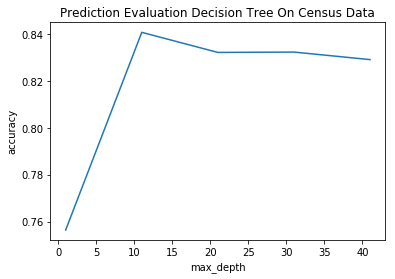

In [128]:
plotAccuracies(accuraciesCensus, depths)

# 7 Titanic Tree Visualization

In [160]:
# import pydot

In [219]:
titanicShallowTree = DecisionTree(max_depth=3, leaf_condition=.84)
trainX, validX, trainY, validY = train_test_split(titanicTrainX, titanicTrainY, test_size=.1, random_state=42)
sizeFeatSubset = trainX.shape[1]
titanicShallowTree.train(trainX, trainY, sizeFeatSubset)

In [236]:
root = titanicShallowTree.root
print('root: feat ' + str(lstTitanicFeatures[root.splitFeatIndex]) + " --> val " + str(root.splitVal))
left = root.left
print('level 1 left: feat ' + str(lstTitanicFeatures[left.splitFeatIndex]) + " --> val " + str(left.splitVal))
right = root.right
print('level 1 right: feat ' + str(lstTitanicFeatures[right.splitFeatIndex]) + " --> val " + str(right.splitVal))
leftLeft = left.left
leftRight = left.right
rightLeft = right.left
rightRight = right.right
print('level 2 left>left feat ' + str(lstTitanicFeatures[leftLeft.splitFeatIndex]) + " --> val " + str(leftLeft.splitVal))
print('level 2 left>right LEAF class ' + str(leftRight.label))

print('level 2 right>left LEAF class ' + str(rightLeft.label))
print('level 2 right>right: feat ' + str(lstTitanicFeatures[rightRight.splitFeatIndex]) + " --> val " + str(rightRight.splitVal))

#leaves
leftLeftLeft = leftLeft.left 
leftLeftRight = leftLeft.right 
rightRightLeft = rightRight.left
rightRightRight = rightRight.right 

print('level 3 left>left>left LEAF class ' + str(leftLeftLeft.label))
print('level 3 left>left>right: LEAF class ' + str(leftLeftRight.label))
print('level 3 right>right>right LEAF class ' + str(rightRightRight.label))
print('level 3 right>right>left LEAF class ' + str(rightRightLeft.label))


root: feat sex_female --> val 0
level 1 left: feat ticket --> val 2668
level 1 right: feat pclass --> val 2.0
level 2 left>left feat age --> val 6.0
level 2 left>right LEAF class 0
level 2 right>left LEAF class 1
level 2 right>right: feat fare --> val 23.25
level 3 left>left>left LEAF class 1
level 3 left>left>right: LEAF class 0
level 3 right>right>right LEAF class 0
level 3 right>right>left LEAF class 1
